# 1. Понимание бизнеса

## 1.1 Цель

Смоделировать предпочтения вин путём извлечения данных из физико-химических свойств (как задачу классификации)

## 1.2 Исходные данные

Есть два набора данных красного и белого португальского вина "Vinho Verde". 

Из-за проблем конфиденциальности и логистики даны только физико-химические(исходные) и сенсорные (выходные) переменные (например, нет данных о сортах винограда, марке вина, цене вина для продажи и т.д.).

Эти наборы данных можно рассматривать как задачу классификации или регрессии.

Классы упорядочены и сбалансированы (например, нормально, что хороших вин больше, чем дешёвых). Алгоритмы обнаружения выбросов могут быть использованы для обнаружения нескольких хороших или дешёвых вин. Также не понятно, все ли входные переменные актуальны. Так что было бы интересно протестировать методы отбора признаков.

Два набора данных были объединены с удалением некоторого количества данных случайным образом.

[Ссылка на Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries


In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import pandas as pd
import numpy as np

# Modelling algorithms of classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer # - заполнение пропусков путём выбора определённой стратегии
from sklearn.preprocessing import Normalizer, scale # нормализация l2, l1 данных и масштабирование
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import RFECV # - Рекурсивное исключение функций с перекрестной проверкой для выбора количества признаков.

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configuration visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [ ]:
def plot_histograms( df , variables , n_rows , n_cols ):
  '''
  Построение гистограммы при получении на вход данных.
  '''
  fig = plt.figure( figsize = ( 16 , 12 ) )
  for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
  fig.tight_layout()  # Improves appearance a bit.
  plt.show()

def plot_distribution( df , var , target , **kwargs ):
  '''Построение распределения при получении на вход данных, переменных, целевой переменной'''
  row = kwargs.get( 'row' , None )
  col = kwargs.get( 'col' , None )
  facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
  facet.map( sns.kdeplot , var , shade= True )
  facet.set( xlim=( 0 , df[ var ].max() ) )
  facet.add_legend()


# Построение распределения по категориальным переменным при получении на вход данных, переменных, целевой переменной
def plot_categories( df , cat , target , **kwargs ):
   row = kwargs.get( 'row' , None )
   col = kwargs.get( 'col' , None )
   facet = sns.FacetGrid( df , row = row , col = col )
   facet.map( sns.barplot , cat , target )
   facet.add_legend()

# Построение тепловой карты корреляции  при получении на вход датасета
def plot_correlation_map( df ):
  corr = wines.corr()
  _ , ax = plt.subplots( figsize =( 12 , 10 ) )
  cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
  _ = sns.heatmap(
      corr, 
      cmap = cmap,
      square=True, 
      cbar_kws={ 'shrink' : .9 }, 
      ax=ax, 
      annot = True, 
      annot_kws = { 'fontsize' : 12 }
    )
  
# Построение датафрейма с типом переменных и их разнообразием с сортировкой
def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [ ]:
wines = pd.read_csv('winequalityN.csv')
print ('Dataset: '  'wines:' , wines.shape)

Dataset: wines: (6497, 13)


## 2.4 Статистика и визуализация

In [ ]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
wines.tail()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
6496,red,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


Информация о признаках:

  Признаковое пространство на входе (на основе физико-химических тестов):
  
  1.  fixed acidity (фиксированная кислотность)
  2.  volatile acidity (летучая кислотность)
  3.  citric acid (лимонная кислота)
  4.  residual sugar (остаточный сахар)
  5.  chlorides (хлориды)
  6.  free sulfur dioxide (свободный диоксид серы)
  7.  total sulfur dioxide (диоксид серы общий)
  8.  density (плотность)
  9.  pH
  10.  sulphates (сульфаты)
  11.  alcohol (алкоголь)

  Выходная переменная (целевая):

  12. quality (score between 0 and 10) (качество)

  [Ссылка на Kaggle](https://www.kaggle.com/rajyellow46/wine-quality)

### 2.4.1 Ключевая информация о переменных

In [ ]:
wines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Можно обратить внимание на то, что в датасете есть пропуски, общее число элементов 6497, а также из категориальных переменных только type вина, который в дальнейшем можно просто заменить на 1 и 0, все остальные признаки это числовые переменные. Признаки пропуски которых надо в дальнейшем заполнить это  ixed acidity, volatile acidity, itric acid, residual sugar, chlorides, pH, sulphates

In [ ]:
wines.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [ ]:
wines[wines['type'] == 'white'].shape

(4898, 13)

In [ ]:
wines[wines['type'] == 'red'].shape

(1599, 13)

In [ ]:
describe_more(wines)

,Variable,Levels,Datatype
0,type,2,object
12,quality,7,int64
3,citric acid,89,float64
1,fixed acidity,106,float64
9,pH,108,float64
10,sulphates,111,float64
11,alcohol,111,float64
6,free sulfur dioxide,135,float64
2,volatile acidity,187,float64
5,chlorides,214,float64


Здесь по каждому признаку видно, что разнообразие самых чисел не такое уж и большее, нет такого, что каждый элемент это уникальное число.

### 2.4.2 Тепловая карта корреляция важных переменных

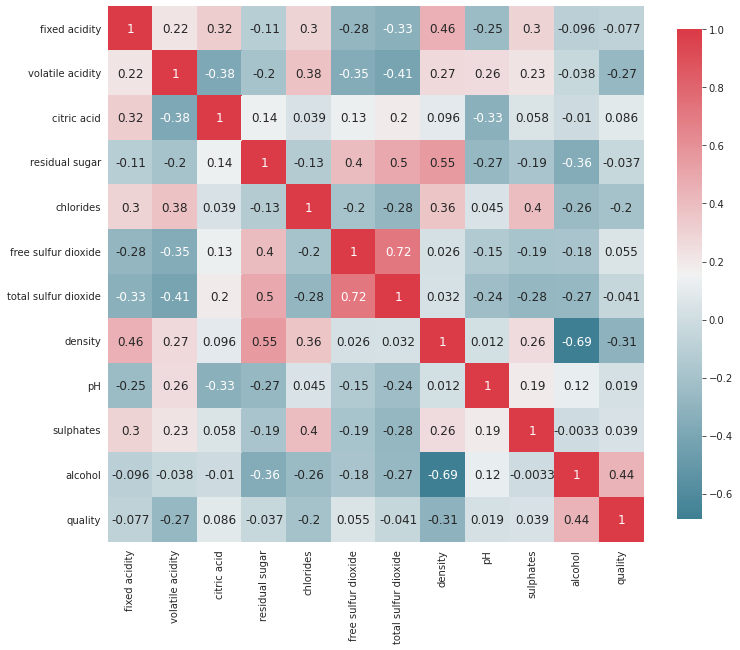

In [ ]:
plot_correlation_map( wines )

По тепловой карте корреляции видим, что наиболее скоррелированные признаки это 0,72 - free sulfur dioxide| total sulfur dioxide, -0.69 - alcohol|density. Обе зависимости логичны.

### 2.4.3 Подробнее про зависимости

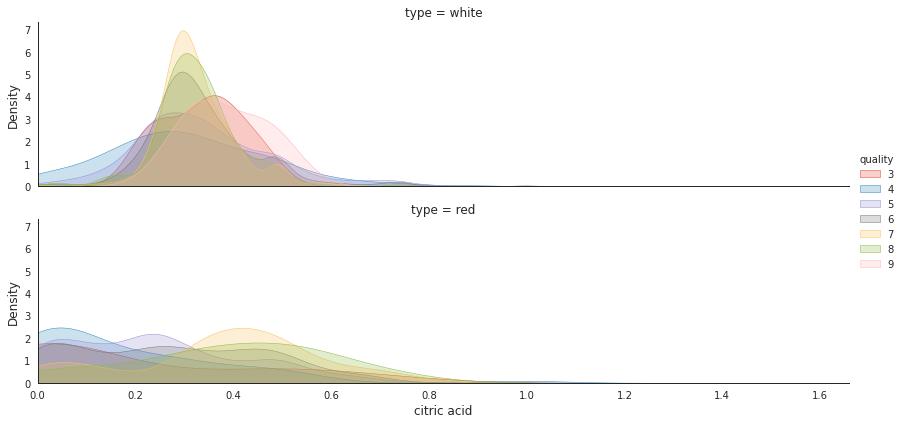

In [ ]:
# Plot distributions of citric acid of wines with different quality
plot_distribution( wines , var = 'citric acid' , target = 'quality' , row = 'type' )

Из данной зависимости можно заметить, что белые вина лежат примерно в большей степени в одной области по содержанию лимонной кислоты, а красные лучшего качества (7-8-9) - имеют большие значения содержания лимонной кислоты.

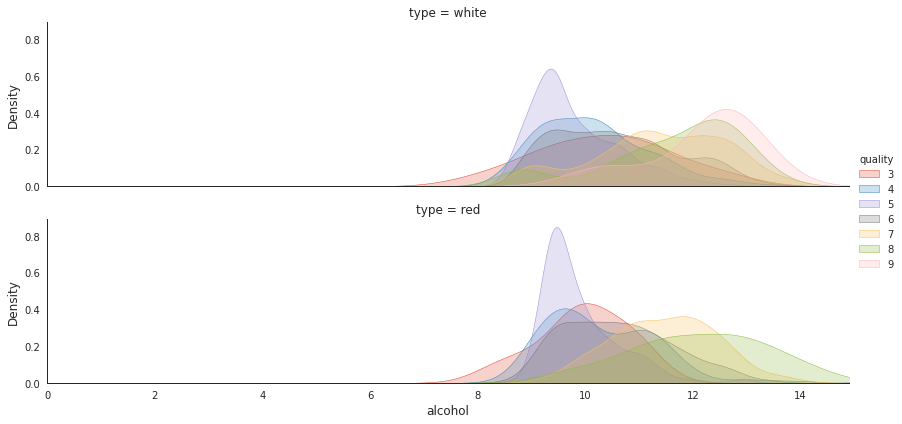

In [ ]:
# Plot distributions of alcohol of wines with different quality
plot_distribution( wines , var = 'alcohol' , target = 'quality' , row = 'type' )

Здесь получилась интересная зависимость на основе данных: чем более алкогольное вино, тем оно более качественное (7-8-9) причём независимо от типа вина.

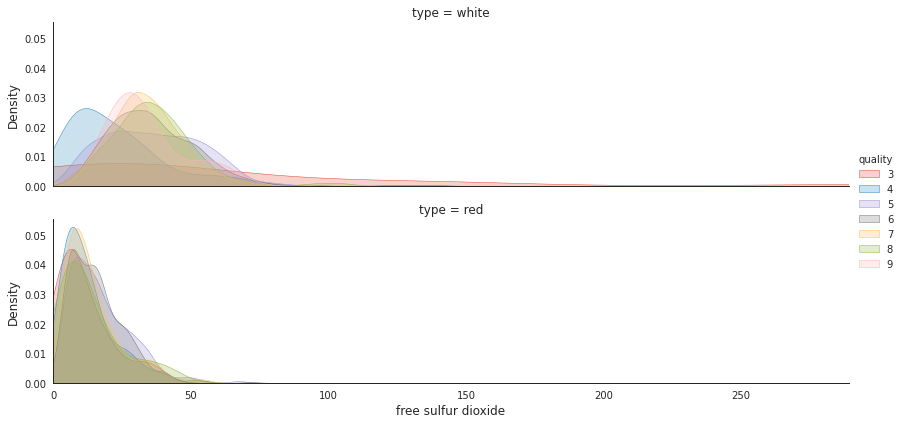

In [ ]:
# Plot distributions of free sulfur dioxide of wines with different quality
plot_distribution( wines , var = 'free sulfur dioxide' , target = 'quality' , row = 'type' )

Тут можно наблюдать, что разные типы вина находятся в разных диапазонах в зависимости от содержания свободного диоксида серы: для белого вина характерны более высокие значения, для красного - минимальные значения.

По-хорошему надо бы исследовать разные типы вина отдельно, но такой цели в задачи заказчика не стоит и данных не слишком много, поэтому будем исследовать всё целиком.

### 2.4.4 Категориальные переменные

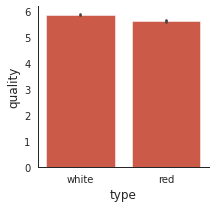

In [ ]:
# Plot quality by type because of one feature is categorial
plot_categories( wines , cat = 'type' , target = 'quality' )

# 3. Data Preparation

## 3.1 Преобразование категориальных переменных в числовые

In [ ]:
# Transform type into binary values 0 and 1
cat_wine = pd.Series( np.where( wines.type == 'white' , 1 , 0 ) , name = 'cat_wine' )

## 3.2 Заполнение пропущенных значений в данных

In [ ]:
# Create dataset with imputting by mean 
imputed = pd.DataFrame()
correct = ['fixed acidity', 'volatile acidity', 'citric acid', 'fixed acidity', 'residual sugar', 'chlorides', 'pH', 'sulphates']

for column in correct:
  imputed[column + '_full'] = wines[column].fillna( wines[column].mean() )
imputed.head()

,fixed acidity_full,volatile acidity_full,citric acid_full,residual sugar_full,chlorides_full,pH_full,sulphates_full
0,7.0,0.27,0.36,20.7,0.045,3.00,0.45
1,6.3,0.30,0.34,1.6,0.049,3.30,0.49
2,8.1,0.28,0.40,6.9,0.050,3.26,0.44
3,7.2,0.23,0.32,8.5,0.058,3.19,0.40
4,7.2,0.23,0.32,8.5,0.058,3.19,0.40


In [ ]:
imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fixed acidity_full     6497 non-null   float64
 1   volatile acidity_full  6497 non-null   float64
 2   citric acid_full       6497 non-null   float64
 3   residual sugar_full    6497 non-null   float64
 4   chlorides_full         6497 non-null   float64
 5   pH_full                6497 non-null   float64
 6   sulphates_full         6497 non-null   float64
dtypes: float64(7)
memory usage: 355.4 KB


Теперь видно, что датасет укомплектован полностью по всем признакам


## 3.3 Сборка финальных датасетов для моделирования

### 3.3.1 Variable selection

Соберём все  по обработанным кусочкам и разобъём в переменные X & y

In [ ]:
full_X = pd.concat( [ imputed , cat_wine, wines ] , axis=1 )
full_X.head()

,fixed acidity_full,volatile acidity_full,citric acid_full,residual sugar_full,chlorides_full,pH_full,sulphates_full,cat_wine,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,3.00,0.45,1,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,3.30,0.49,1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,3.26,0.44,1,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,3.19,0.40,1,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,3.19,0.40,1,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
y = full_X['quality']
X = full_X.drop(['type', 'fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','pH','sulphates','quality'], axis=1)
X.head()

,fixed acidity_full,volatile acidity_full,citric acid_full,residual sugar_full,chlorides_full,pH_full,sulphates_full,cat_wine,free sulfur dioxide,total sulfur dioxide,density,alcohol
0,7.0,0.27,0.36,20.7,0.045,3.00,0.45,1,45.0,170.0,1.0010,8.8
1,6.3,0.30,0.34,1.6,0.049,3.30,0.49,1,14.0,132.0,0.9940,9.5
2,8.1,0.28,0.40,6.9,0.050,3.26,0.44,1,30.0,97.0,0.9951,10.1
3,7.2,0.23,0.32,8.5,0.058,3.19,0.40,1,47.0,186.0,0.9956,9.9
4,7.2,0.23,0.32,8.5,0.058,3.19,0.40,1,47.0,186.0,0.9956,9.9



## 3.4.2 Создание датасетов

In [ ]:
# Create all datasets that are necessary to train, validate and test models
train_valid_X = X[ 0 : 3000]
test_X = X[ 3000 : ]
train_valid_y = y[ 0 : 3000]
test_y = y[ 3000 : ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape, test_X.shape)

(6497, 12) (2100, 12) (900, 12) (2100,) (900,) (3497, 12)



## 3.4.3 Важность признаков

1.0


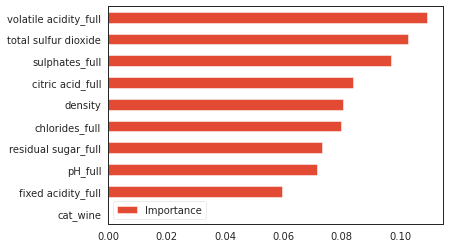

In [ ]:
plot_variable_importance(train_X,
                         train_y)

Важность признаков играет больше значение в моделировании. По горизонтальной гистограмме видно, что все признаки, кроме категории вина имеют значение при моделировании, поэтому оставим все.


# 4. Моделирование

## 4.1 Выбор модели

In [ ]:
model_list = {
    'Tree' : DecisionTreeClassifier(max_depth=10),
    'LogReg' : LogisticRegression(),
    'Kneigh' : KNeighborsClassifier(),
    'GaussNB' : GaussianNB(),
    'SVC' : SVC(),
    'linSVC' : LinearSVC(),
    'Forest' : RandomForestClassifier(max_depth=10),
    'Booster' : GradientBoostingClassifier()
}

## 4.2 Обучение модели

In [ ]:
print('Model name         Train_Score         Valid_Score           Test_Score\t')
for name, model  in model_list.items():
  model.fit( train_X , train_y )
  print(name,'              ', '%.3f' % model.score( train_X , train_y ), '              ', '%.3f' % model.score( train_valid_X , train_valid_y ), '              ', '%.3f' % model.score( test_X , test_y  ))

Model name         Train_Score         Valid_Score           Test_Score	
Tree                0.785                0.705                0.385
LogReg                0.438                0.444                0.429
Kneigh                0.625                0.572                0.393
GaussNB                0.447                0.442                0.288
SVC                0.418                0.418                0.454
linSVC                0.436                0.438                0.498
Forest                0.885                0.805                0.463
Booster                0.786                0.725                0.334


# 5. Оценка

## 5.1 Модель 

In [ ]:
# Score the model

Смотри результаты кода выше.

Можно сделать вывод последовательно. Участвовало 8 моделей, из них лучше всего на valid выборке справились топ-5: Forest(0.805), Booster, Tree,  Kneigh, LogReg (0.444). Однако на тестовой выборке на финале лучше всего справились топ-3: linSVC(0.498), Forest(0.463), SVC(0.454). Пожалуй из всех них я бы выбрал модель Forest (RandomForestClassifier(max_depth=10))  как лучше всего справившуюся на всех выборках.